# ASCII Tree Diagram Distance Probe + Ablations

This notebook runs the full experiment pipeline:
1. Load the dataset and model.
2. Collect model embeddings for ASCII tree nodes across the dataset.
3. Train/evaluate a distance probe (with optional PCA).
4. Generate responses while ablating the probe subspace and baselines.
5. Visualize ablation effects.

Note: running over all 500 examples can be slow on local hardware.

In [1]:
from __future__ import annotations

import re
import sys
from pathlib import Path
from typing import List, Tuple

import numpy as np

# Resolve project root so imports work when running from cutter/notebooks.
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / 'cutter').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from cutter.utils.tree.datasets import load_traversal_dataset
from cutter.utils.tree.encoding import DEVICE, collect_hidden_states_for_spans, load_reasoning_model, set_global_seed
from cutter.utils.shared.paths import dataset_path_from_tag, dataset_tag
from cutter.utils.shared.basic import parse_range_arg
from cutter.utils.tree.probing import evaluate_probes
from cutter.utils.tree.trees import DistanceProbeConfig, pairwise_tree_distances, tree_depth
import cutter.scripts.evaluate_probe as eval_probe
import cutter.scripts.intervene as intervene

In [2]:
# Configuration
DEPTH_RANGE = [1, 3]
STEPS_RANGE = [1]
NUM_SAMPLES = 500
MIN_DEPTH, MAX_DEPTH = parse_range_arg(DEPTH_RANGE, "depth-range", min_value=1)
MIN_STEPS, MAX_STEPS = parse_range_arg(STEPS_RANGE, "steps-range", min_value=1)
STEPS_TAG = (MIN_STEPS, MAX_STEPS) if MIN_STEPS != MAX_STEPS else MIN_STEPS
DATASET_TAG = dataset_tag(MIN_DEPTH, MAX_DEPTH, NUM_SAMPLES, STEPS_TAG)
MODEL_ID = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B'
LAYER_IDX = 22
LAYER_MODE = 'layer'
PCA_COMPONENTS = 10
TRAIN_SPLIT = 0.5
SEED = 42

PROJ_DIM = 4
PROBE_STEPS = 1500
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 1e-2
PAIR_WEIGHTING = 'inverse_freq'
FIT_GEOMETRY = 'euclidean'
DEPTH_ALPHA = 1e-2
NORMALIZE_TREE = False

MAX_NEW_TOKENS = 2000
NUM_RANDOM = 1
LIMIT_EXAMPLES = 20  # 0 = all


In [3]:
set_global_seed(SEED)
dataset_fp = dataset_path_from_tag(DATASET_TAG)
records = load_traversal_dataset(dataset_fp)

rng = np.random.default_rng(SEED)
indices = np.arange(len(records))
rng.shuffle(indices)
split = int(len(indices) * TRAIN_SPLIT)
train_ids = set(indices[:split].tolist())

print(f'Loaded {len(records)} examples from {dataset_fp}')
print(f'Train split: {len(train_ids)} | Test split: {len(records) - len(train_ids)}')

Loaded 500 examples from /workspace/SPAR/cutter/data/depth1-3_n500/dataset/traversal_paths.jsonl
Train split: 250 | Test split: 250


In [4]:
print(f'Loading model {MODEL_ID} on {DEVICE}...')
tokenizer, model = load_reasoning_model(MODEL_ID, device=DEVICE, use_half_precision=True)
model.eval()
if not getattr(tokenizer, 'is_fast', False):
    raise ValueError('This notebook requires a fast tokenizer to align character offsets.')
print('Model loaded.')

Loading model deepseek-ai/DeepSeek-R1-Distill-Qwen-7B on cuda...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded.


In [5]:
def _extract_tree_block(prompt: str) -> Tuple[str, int]:
    start = prompt.find('Tree Graph:')
    if start == -1:
        raise ValueError('Tree diagram header not found in prompt.')
    end = prompt.find('\n\nTask:', start)
    if end == -1:
        end = prompt.find('\nTask:', start)
    if end == -1:
        end = len(prompt)
    return prompt[start:end], start

def _extract_diagram_spans(prompt: str) -> Tuple[List[int], List[Tuple[int, int]]]:
    block, offset = _extract_tree_block(prompt)
    labels: List[int] = []
    spans: List[Tuple[int, int]] = []
    for match in re.finditer(r'\b\d+\b', block):
        labels.append(int(match.group(0)))
        spans.append((offset + match.start(), offset + match.end()))
    if not labels:
        raise ValueError('No node labels found in tree diagram.')
    return labels, spans

def _invert_mapping(mapping: List[int]) -> dict[int, int]:
    return {label: idx for idx, label in enumerate(mapping)}

In [6]:
X_list: List[np.ndarray] = []
node_ids: List[int] = []
depths: List[int] = []
example_ids: List[int] = []
train_idx: List[int] = []
test_idx: List[int] = []

cursor = 0
for idx, rec in enumerate(records):
    labels, spans = _extract_diagram_spans(rec.prompt)
    inv_map = _invert_mapping(rec.label_mapping) if rec.label_mapping else None
    canonical_ids = [inv_map.get(label, label) if inv_map else label for label in labels]

    embeddings, _, _ = collect_hidden_states_for_spans(
        rec.prompt,
        spans,
        tokenizer,
        model,
        layer_idx=LAYER_IDX,
        layer_mode=LAYER_MODE,
    )
    if len(embeddings) != len(canonical_ids):
        raise RuntimeError(f'Embedding/span count mismatch for example {idx}.')

    for emb, node_id in zip(embeddings, canonical_ids):
        X_list.append(np.asarray(emb, dtype=np.float32))
        node_ids.append(int(node_id))
        depths.append(tree_depth(int(node_id)))
        example_ids.append(idx)
        if idx in train_ids:
            train_idx.append(cursor)
        else:
            test_idx.append(cursor)
        cursor += 1

print(f'Collected {len(X_list)} node embeddings across {len(records)} examples.')

Collected 6724 node embeddings across 500 examples.


In [7]:
X = np.vstack(X_list).astype(np.float32)
node_arr = np.array(node_ids, dtype=np.int64)
depth_arr = np.array(depths, dtype=np.float32)
example_arr = np.array(example_ids, dtype=np.int64)
train_idx_arr = np.array(train_idx, dtype=int)
test_idx_arr = np.array(test_idx, dtype=int)

dist_mat = pairwise_tree_distances(node_arr)
data = {
    'X': X,
    'D': dist_mat,
    'depth': depth_arr,
    'example_ids': example_arr,
    'train_idx': train_idx_arr,
    'test_idx': test_idx_arr,
}

encodings = {LAYER_IDX: data}

pca_info = {}
if PCA_COMPONENTS is not None and PCA_COMPONENTS >= 0:
    encodings, pca_info = eval_probe._apply_pca_to_encodings(encodings, PCA_COMPONENTS, SEED)
    print(f'Applied PCA with {PCA_COMPONENTS} components (fit on train split).')

Applied PCA with 10 components (fit on train split).


In [8]:
max_tree_depth = max((rec.depth for rec in records), default=1)
normalize_tree = max_tree_depth if NORMALIZE_TREE else None

cfg = DistanceProbeConfig(
    proj_dim=PROJ_DIM,
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    steps=PROBE_STEPS,
    seed=SEED,
    fit_geometry=FIT_GEOMETRY,
    pair_weighting=PAIR_WEIGHTING,
)

probe_results = evaluate_probes(
    {'layer': encodings[LAYER_IDX]},
    cfg,
    device=DEVICE,
    normalize_tree=normalize_tree,
    depth_alpha=DEPTH_ALPHA,
)

layer_result = probe_results['layer']
projection = np.asarray(layer_result['projection'], dtype=np.float32)

components = None
if LAYER_IDX in pca_info:
    components = np.asarray(pca_info[LAYER_IDX].get('components', []), dtype=np.float32)

if components is not None and components.size:
    projection = components.T @ projection

probe_basis_np = intervene._orthonormal_basis(projection)
probe_basis = np.asarray(probe_basis_np, dtype=np.float32)
hidden_dim = probe_basis.shape[0]
basis_rank = probe_basis.shape[1]

pca_basis = None
if components is not None and components.size:
    take = min(PROJ_DIM, components.shape[0])
    if take > 0:
        pca_basis = components[:take].T.astype(np.float32)

print(f'Probe basis rank {basis_rank} | hidden dim {hidden_dim}')
if pca_basis is not None:
    print(f'PCA basis rank {pca_basis.shape[1]}')

Probe basis rank 4 | hidden dim 3584
PCA basis rank 4


In [9]:
target_layer = intervene._resolve_layer_module(model, LAYER_IDX)
model_dtype = next(model.parameters()).dtype
probe_basis_t = intervene.torch.tensor(probe_basis, dtype=intervene.torch.float32, device=model.device).to(dtype=model_dtype)
pca_basis_t = None
if pca_basis is not None:
    pca_basis_t = intervene.torch.tensor(pca_basis, dtype=intervene.torch.float32, device=model.device).to(dtype=model_dtype)

max_examples = LIMIT_EXAMPLES if LIMIT_EXAMPLES > 0 else 0
exact_seen = 0
processed = 0

per_example = []
baseline_exact = []
baseline_partial = []
probe_exacts = []
probe_partials = []
probe_logit_diffs = []
pca_exacts = []
pca_partials = []
pca_logit_diffs = []
zero_exacts = []
zero_partials = []
zero_logit_diffs = []
random_exacts = [[] for _ in range(NUM_RANDOM)]
random_partials = [[] for _ in range(NUM_RANDOM)]
random_logit_diffs = [[] for _ in range(NUM_RANDOM)]

for idx, rec in enumerate(records):
    if max_examples and exact_seen >= max_examples:
        break
    prompt_text = intervene._render_prompt(tokenizer, rec.prompt)
    answer_text = intervene._build_answer_text(rec.path)
    answer_mask = intervene._answer_token_mask(answer_text, tokenizer)
    node_token_ids = intervene._node_token_ids(rec.depth, tokenizer)

    base_gen = intervene._run_generation(
        prompt_text,
        tokenizer=tokenizer,
        model=model,
        max_new_tokens=MAX_NEW_TOKENS,
        ground_truth_path=rec.path,
    )
    processed += 1
    if not base_gen.exact_match:
        if processed % 25 == 0:
            print(f'Processed {processed} examples; exact kept {exact_seen}')
        continue
    exact_seen += 1

    base_logits = intervene._compute_answer_logits(
        prompt_text=prompt_text,
        prefix_text='',
        answer_text=answer_text,
        tokenizer=tokenizer,
        model=model,
        target_layer=None,
    )

    probe_gen = intervene._run_generation(
        prompt_text,
        tokenizer=tokenizer,
        model=model,
        max_new_tokens=MAX_NEW_TOKENS,
        ablation_basis=probe_basis_t,
        target_layer=target_layer,
        ground_truth_path=rec.path,
    )
    probe_logits = intervene._compute_answer_logits(
        prompt_text=prompt_text,
        prefix_text='',
        answer_text=answer_text,
        tokenizer=tokenizer,
        model=model,
        ablation_basis=probe_basis_t,
        target_layer=target_layer,
    )
    probe_logit_gap = intervene._mean_abs_node_logit_diff(base_logits, probe_logits, node_token_ids, answer_mask)

    pca_gen = None
    pca_logit_gap = float('nan')
    if pca_basis_t is not None:
        pca_gen = intervene._run_generation(
            prompt_text,
            tokenizer=tokenizer,
            model=model,
            max_new_tokens=MAX_NEW_TOKENS,
            ablation_basis=pca_basis_t,
            target_layer=target_layer,
            ground_truth_path=rec.path,
        )
        pca_logits = intervene._compute_answer_logits(
            prompt_text=prompt_text,
            prefix_text='',
            answer_text=answer_text,
            tokenizer=tokenizer,
            model=model,
            ablation_basis=pca_basis_t,
            target_layer=target_layer,
        )
        pca_logit_gap = intervene._mean_abs_node_logit_diff(base_logits, pca_logits, node_token_ids, answer_mask)

    zero_gen = intervene._run_generation(
        prompt_text,
        tokenizer=tokenizer,
        model=model,
        max_new_tokens=MAX_NEW_TOKENS,
        target_layer=target_layer,
        ablation_zero=True,
        ground_truth_path=rec.path,
    )
    zero_logits = intervene._compute_answer_logits(
        prompt_text=prompt_text,
        prefix_text='',
        answer_text=answer_text,
        tokenizer=tokenizer,
        model=model,
        target_layer=target_layer,
        ablation_zero=True,
    )
    zero_logit_gap = intervene._mean_abs_node_logit_diff(base_logits, zero_logits, node_token_ids, answer_mask)

    random_runs = []
    for ridx in range(NUM_RANDOM):
        seed = SEED + 1 + ridx * 10000 + idx
        rand_basis = intervene._sample_random_basis(hidden_dim, basis_rank, seed).to(model.device, dtype=model_dtype)
        rand_gen = intervene._run_generation(
            prompt_text,
            tokenizer=tokenizer,
            model=model,
            max_new_tokens=MAX_NEW_TOKENS,
            ablation_basis=rand_basis,
            target_layer=target_layer,
            ground_truth_path=rec.path,
        )
        rand_logits = intervene._compute_answer_logits(
            prompt_text=prompt_text,
            prefix_text='',
            answer_text=answer_text,
            tokenizer=tokenizer,
            model=model,
            ablation_basis=rand_basis,
            target_layer=target_layer,
        )
        rand_gap = intervene._mean_abs_node_logit_diff(base_logits, rand_logits, node_token_ids, answer_mask)
        random_exacts[ridx].append(float(rand_gen.exact_match))
        random_partials[ridx].append(float(rand_gen.partial_score))
        random_logit_diffs[ridx].append(rand_gap)
        random_runs.append({
            'seed': seed,
            'exact_match': rand_gen.exact_match,
            'partial_score': rand_gen.partial_score,
            'logit_diff': rand_gap,
        })

    baseline_exact.append(float(base_gen.exact_match))
    baseline_partial.append(float(base_gen.partial_score))
    probe_exacts.append(float(probe_gen.exact_match))
    probe_partials.append(float(probe_gen.partial_score))
    probe_logit_diffs.append(probe_logit_gap)
    if pca_gen is not None:
        pca_exacts.append(float(pca_gen.exact_match))
        pca_partials.append(float(pca_gen.partial_score))
        pca_logit_diffs.append(pca_logit_gap)
    zero_exacts.append(float(zero_gen.exact_match))
    zero_partials.append(float(zero_gen.partial_score))
    zero_logit_diffs.append(zero_logit_gap)

    per_example.append({
        'example_id': idx,
        'depth': rec.depth,
        'baseline': {
            'exact_match': base_gen.exact_match,
            'partial_score': base_gen.partial_score,
            'logit_diff': 0.0,
        },
        'probe_ablation': {
            'exact_match': probe_gen.exact_match,
            'partial_score': probe_gen.partial_score,
            'logit_diff': probe_logit_gap,
        },
        'pca_ablation': {
            'exact_match': pca_gen.exact_match if pca_gen is not None else False,
            'partial_score': pca_gen.partial_score if pca_gen is not None else float('nan'),
            'logit_diff': pca_logit_gap,
        },
        'zero_ablation': {
            'exact_match': zero_gen.exact_match,
            'partial_score': zero_gen.partial_score,
            'logit_diff': zero_logit_gap,
        },
        'random_ablation': random_runs,
    })

    if (idx + 1) % 25 == 0 or (idx + 1) == max_examples:
        print(f'Exact kept {exact_seen}/{max_examples or "all"} (processed {processed})')

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Exact kept 13/20 (processed 20)
Processed 25 examples; exact kept 16


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

PROBE_COLOR = '#1f77b4'
RANDOM_COLOR = '#d62728'
PCA_COLOR = '#7c3aed'
ZERO_COLOR = '#111827'
BASELINE_COLOR = '#4b5563'

rows = []
for rec in per_example:
    base = rec['baseline']
    probe = rec['probe_ablation']
    pca = rec.get('pca_ablation', {})
    zero = rec.get('zero_ablation', {})
    rand = rec['random_ablation'][0] if rec.get('random_ablation') else {}
    rows.append({
        'example_id': rec.get('example_id'),
        'depth': rec.get('depth'),
        'baseline_exact': bool(base.get('exact_match')),
        'baseline_partial': float(base.get('partial_score', 0.0)),
        'probe_exact': bool(probe.get('exact_match')),
        'probe_partial': float(probe.get('partial_score', 0.0)),
        'probe_logit_diff': float(probe.get('logit_diff', np.nan)),
        'pca_exact': bool(pca.get('exact_match')) if pca else False,
        'pca_partial': float(pca.get('partial_score', np.nan)) if pca else float('nan'),
        'pca_logit_diff': float(pca.get('logit_diff', np.nan)) if pca else float('nan'),
        'zero_exact': bool(zero.get('exact_match')) if zero else False,
        'zero_partial': float(zero.get('partial_score', np.nan)) if zero else float('nan'),
        'zero_logit_diff': float(zero.get('logit_diff', np.nan)) if zero else float('nan'),
        'rand_exact': bool(rand.get('exact_match')) if rand else False,
        'rand_partial': float(rand.get('partial_score', np.nan)) if rand else float('nan'),
        'rand_logit_diff': float(rand.get('logit_diff', np.nan)) if rand else float('nan'),
    })

df = pd.DataFrame(rows)
df['probe_delta_exact'] = df['probe_exact'].astype(float) - df['baseline_exact'].astype(float)
df['pca_delta_exact'] = df['pca_exact'].astype(float) - df['baseline_exact'].astype(float)
df['zero_delta_exact'] = df['zero_exact'].astype(float) - df['baseline_exact'].astype(float)
df['rand_delta_exact'] = df['rand_exact'].astype(float) - df['baseline_exact'].astype(float)
df['probe_delta_partial'] = df['probe_partial'] - df['baseline_partial']
df['pca_delta_partial'] = df['pca_partial'] - df['baseline_partial']
df['zero_delta_partial'] = df['zero_partial'] - df['baseline_partial']
df['rand_delta_partial'] = df['rand_partial'] - df['baseline_partial']

df.head()

,example_id,depth,baseline_exact,baseline_partial,probe_exact,probe_partial,probe_logit_diff,pca_exact,pca_partial,pca_logit_diff,...,rand_partial,rand_logit_diff,probe_delta_exact,pca_delta_exact,zero_delta_exact,rand_delta_exact,probe_delta_partial,pca_delta_partial,zero_delta_partial,rand_delta_partial
0,2,1,True,1.0,True,1.000000,0.730469,True,1.000000,0.718750,...,1.000000,0.101562,0.0,0.0,-1.0,0.0,0.000000,0.000000,-1.0,0.000000
1,3,3,True,1.0,True,1.000000,1.134152,False,0.166667,0.884598,...,0.000000,0.170647,0.0,-1.0,-1.0,-1.0,0.000000,-0.833333,-1.0,-1.000000
2,4,3,True,1.0,True,1.000000,0.824479,False,0.000000,1.167318,...,1.000000,0.132031,0.0,-1.0,-1.0,0.0,0.000000,-1.000000,-1.0,0.000000
3,6,1,True,1.0,True,1.000000,0.571289,True,1.000000,0.741211,...,1.000000,0.096680,0.0,0.0,-1.0,0.0,0.000000,0.000000,-1.0,0.000000
4,9,3,True,1.0,False,0.142857,1.575608,False,0.142857,1.418229,...,0.285714,0.107639,-1.0,-1.0,-1.0,-1.0,-0.857143,-0.857143,-1.0,-0.714286


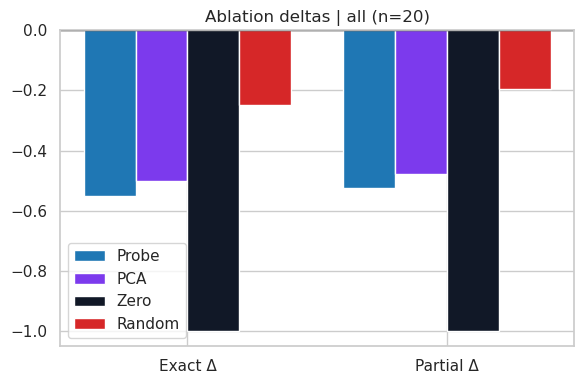

In [11]:
def bucket_deltas(sub):
    baseline_exact_rate = sub['baseline_exact'].mean()
    baseline_partial_mean = sub['baseline_partial'].mean()
    return {
        'count': len(sub),
        'probe_exact_delta': sub['probe_exact'].mean() - baseline_exact_rate,
        'pca_exact_delta': sub['pca_exact'].mean() - baseline_exact_rate,
        'zero_exact_delta': sub['zero_exact'].mean() - baseline_exact_rate,
        'rand_exact_delta': sub['rand_exact'].mean() - baseline_exact_rate,
        'probe_partial_delta': sub['probe_partial'].mean() - baseline_partial_mean,
        'pca_partial_delta': sub['pca_partial'].mean() - baseline_partial_mean,
        'zero_partial_delta': sub['zero_partial'].mean() - baseline_partial_mean,
        'rand_partial_delta': sub['rand_partial'].mean() - baseline_partial_mean,
    }

def plot_delta_bars(label: str, stats: dict):
    fig, ax = plt.subplots(figsize=(6, 4))
    metrics = ['Exact Δ', 'Partial Δ']
    probe_vals = [stats['probe_exact_delta'], stats['probe_partial_delta']]
    pca_vals = [stats['pca_exact_delta'], stats['pca_partial_delta']]
    zero_vals = [stats['zero_exact_delta'], stats['zero_partial_delta']]
    rand_vals = [stats['rand_exact_delta'], stats['rand_partial_delta']]
    x = np.arange(len(metrics))
    width = 0.2
    ax.bar(x - 1.5 * width, probe_vals, width, label='Probe', color=PROBE_COLOR)
    ax.bar(x - 0.5 * width, pca_vals, width, label='PCA', color=PCA_COLOR)
    ax.bar(x + 0.5 * width, zero_vals, width, label='Zero', color=ZERO_COLOR)
    ax.bar(x + 1.5 * width, rand_vals, width, label='Random', color=RANDOM_COLOR)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.axhline(0, color='black', linewidth=1)
    ax.set_title('Ablation deltas | {} (n={})'.format(label, stats['count']))
    ax.legend()
    plt.tight_layout()

plot_delta_bars('all', bucket_deltas(df))

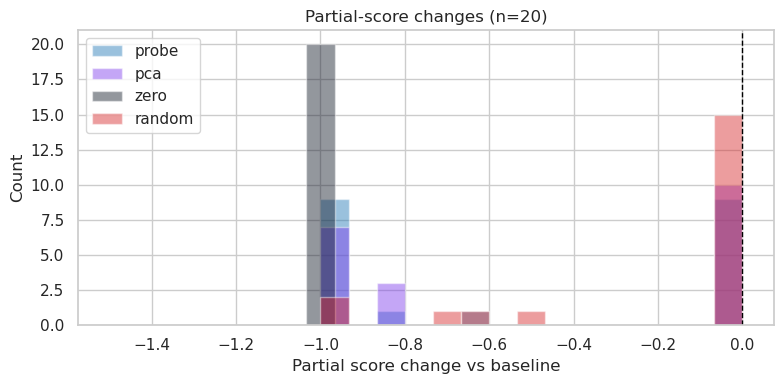

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df['probe_delta_partial'], bins=15, alpha=0.45, label='probe', color=PROBE_COLOR)
ax.hist(df['pca_delta_partial'], bins=15, alpha=0.45, label='pca', color=PCA_COLOR)
ax.hist(df['zero_delta_partial'], bins=15, alpha=0.45, label='zero', color=ZERO_COLOR)
ax.hist(df['rand_delta_partial'], bins=15, alpha=0.45, label='random', color=RANDOM_COLOR)
ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.set_title('Partial-score changes (n={})'.format(len(df)))
ax.set_xlabel('Partial score change vs baseline')
ax.set_ylabel('Count')
ax.legend()
plt.tight_layout()

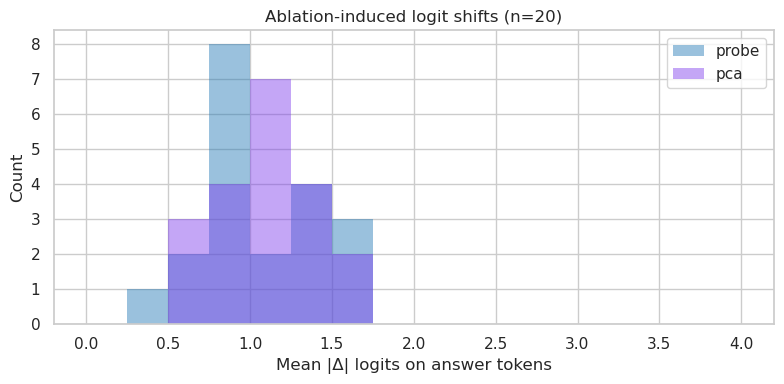

In [13]:
probe_vals = df['probe_logit_diff'].dropna()
pca_vals = df['pca_logit_diff'].dropna()
zero_vals = df['zero_logit_diff'].dropna()
rand_vals = df['rand_logit_diff'].dropna()
combined = pd.concat([probe_vals, pca_vals, zero_vals, rand_vals])
if not combined.empty:
    bins = np.linspace(0, 4, 17)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(probe_vals, bins=bins, alpha=0.45, label='probe', color=PROBE_COLOR, edgecolor='none')
    ax.hist(pca_vals, bins=bins, alpha=0.45, label='pca', color=PCA_COLOR, edgecolor='none')
    # ax.hist(zero_vals, bins=bins, alpha=0.45, label='zero', color=ZERO_COLOR, edgecolor='none')
    # ax.hist(rand_vals, bins=bins, alpha=0.45, label='random', color=RANDOM_COLOR, edgecolor='none')
    # ax.set_xlim(0, 2)
    ax.set_xlabel('Mean |Δ| logits on answer tokens')
    ax.set_ylabel('Count')
    ax.set_title('Ablation-induced logit shifts (n={})'.format(len(df)))
    ax.legend()
    plt.tight_layout()
else:
    print('No logit difference data available.')